**Business Understanding**

The use of AirBnb as a means of staying a new city has certainly gained a lot of traction over the past decade or so. Their pricing, reviews left by previous customers and location are just a few factors which can heavly impact if other people choose to stay in the same place or not. We will be looking at the AirBnb data from 2016/17, specifically in Seattle and Boston, to try and determine which location provides the best value for money. To do this, we will answer four questions;

- What is the mean cost of an AirBnb in either location?
- Does the time of booking impact the cost?
- Where can we get the best value for money?
- Is there any other information we could abstract from the written reviews?

**Data Understanding**

To answer our questions, we will be looking at 3 different files for each location - calendar, listings and reviews.

In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import the 3 files for each location
seattle_calendar = pd.read_csv('//GBMLVFILFS01N02.rbsres01.net/home8$/Evanrdo/Personal/DS Nanodegree/seattle_calendar.csv')
seattle_listings = pd.read_csv('//GBMLVFILFS01N02.rbsres01.net/home8$/Evanrdo/Personal/DS Nanodegree/seattle_listings.csv')
seattle_reviews = pd.read_csv('//GBMLVFILFS01N02.rbsres01.net/home8$/Evanrdo/Personal/DS Nanodegree/seattle_reviews.csv')
boston_calendar = pd.read_csv('//GBMLVFILFS01N02.rbsres01.net/home8$/Evanrdo/Personal/DS Nanodegree/boston_calendar.csv')
boston_listings = pd.read_csv('//GBMLVFILFS01N02.rbsres01.net/home8$/Evanrdo/Personal/DS Nanodegree/boston_listings.csv')
boston_reviews = pd.read_csv('//GBMLVFILFS01N02.rbsres01.net/home8$/Evanrdo/Personal/DS Nanodegree/boston_reviews.csv')

In [256]:
display(seattle_listings.head(1))

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07


In [257]:
#check the number of unique ids that is attached to both locations.
display(len(seattle_listings['id'].unique().tolist()))
display(len(boston_listings['id'].unique().tolist()))

3818

3585

Examine the listings file. Roughly, the same amount of listings in both cities.

In [258]:
display(seattle_calendar.head(1))

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00


In [259]:
#check what the min and max date value is for both cities.
display(seattle_calendar['date'].min())
display(seattle_calendar['date'].max())
display(boston_calendar['date'].min())
display(boston_calendar['date'].max())

'2016-01-04'

'2017-01-02'

'2016-09-06'

'2017-09-05'

Examine the calendar file. We can see the price column is an integer, meaning numerical calculations cannot be done. Furthermore, the available column is categroical, which prevents the ability to do counts. We should also be aware that the date period for the two cities are not equal and therefore be cautious when comparing the data.

In [260]:
display(seattle_reviews.head(1))

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...


In [261]:
#what different type of comments do we see and how much diversity is there
display(seattle_reviews['comments'].value_counts().head())

comments
The host canceled this reservation the day before arrival. This is an automated posting.    57
The reservation was canceled the day before arrival. This is an automated posting.          48
The host canceled this reservation 4 days before arrival. This is an automated posting.     22
The reservation was canceled 2 days before arrival. This is an automated posting.           19
The host canceled this reservation 2 days before arrival. This is an automated posting.     17
Name: count, dtype: int64

Examine the reviews file. Working with the reviews dataframe will mainly require a key word search to pull out the relevant comments.

**Data Preparation**

Now we know what each files contains, we should alter some columns to allow for further analysis to be done in an effective way.

In [262]:
# look at how many nulls in each column
display(seattle_calendar['available'].isnull().mean())
display(seattle_calendar['price'].isnull().mean())
display(boston_calendar['available'].isnull().mean())
display(boston_calendar['price'].isnull().mean())

0.0

0.32938998399793334

0.0

0.5087157820748879

There's a lot of null 'price' rows, however, these don't need to be drop if we're only exploring the 'available' columns for example. This will be discussed further in later sections.

In [263]:
# to be able to do calculation involving the pricing, it needs to be converted to a float type.
def price_col_to_numeric(df, col_name):
    """
    takes a dataframe and converts a column from an integr type fo a float tyoe
    ---
    input:
       df = dataframe
       col_name = name of the column you want to convert to numerical.
    output:
       df with price column converted to float type.
    """
    df[col_name] = df[col_name].str.replace('$', '')
    df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
    return df

In [264]:
# apply this function to the relevant dataframes.
seattle_calendar = price_col_to_numeric(seattle_calendar, 'price')
boston_calendar = price_col_to_numeric(boston_calendar, 'price')

The column 'available' is a categorical varible, therefore we create a new function which will create a new column, called 'available', which will be assigned the value 1 or 0 dependent if the letting is booked or not for that date. This allows for more in-depth analysis.

In [265]:
def booked(row):
    """
    Create a new numerical column.
    ---
    input:
       row = name of the new column you want to create.
    output:
       df with new column.
    """
    if row['available'] == 't':
       return 1
    if row['available'] != 't':
       return 0

In [266]:
# apply the booked function to the relevant dataframes.
seattle_calendar['booked'] = seattle_calendar.apply(booked, axis=1)
boston_calendar['booked'] = boston_calendar.apply(booked, axis=1)

**Evaluation**

**Question 1 - What is the mean cost of an AirBnb in either location?**

By taking an average across a 12 month period, we get a basic metric which gives us a high-level indication of price.

In [267]:
seattle_calendar_price = seattle_calendar.dropna(subset= ["price"])
boston_calendar_price = boston_calendar.dropna(subset= ["price"])

As we're initially only looking at the price of these cities, it's best to drop the null values for this piece of analysis.

In [268]:
display(seattle_calendar_price['price'].mean())
display(boston_calendar_price['price'].mean())

137.19222676140043

192.45390955690283

We can see that the average cost of an AirBnb listing in Boston is more expensive than in Seattle.

**Question 2 - Does the time of booking impact the cost?**

By grouping the dataframe by date, then summing the 'booked' column, this shows us how many listings are occupied per day. From this, we can calculate what is the peak times for both cities.

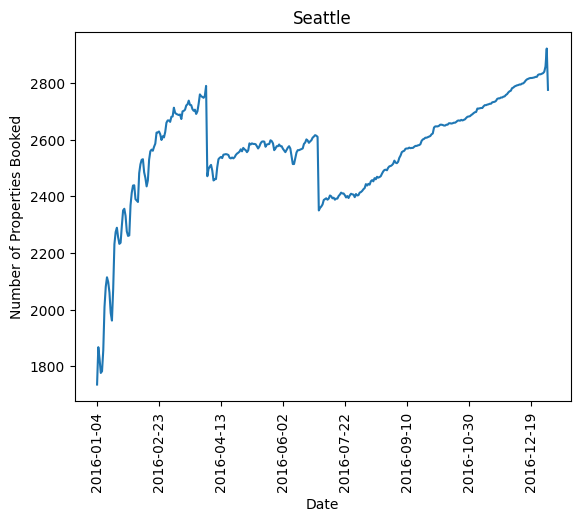

In [269]:
# group the data by date and see how many bookings occur each day. This data can then be plotted on a line graph to
# aid the visualization of the output.
popularity_by_date_seattle = seattle_calendar.groupby('date')['booked'].sum()
popularity_by_date_seattle.plot(kind='line', rot=90);
plt.title('Seattle')
plt.xlabel("Date")
plt.ylabel("Number of Properties Booked")
plt.show()

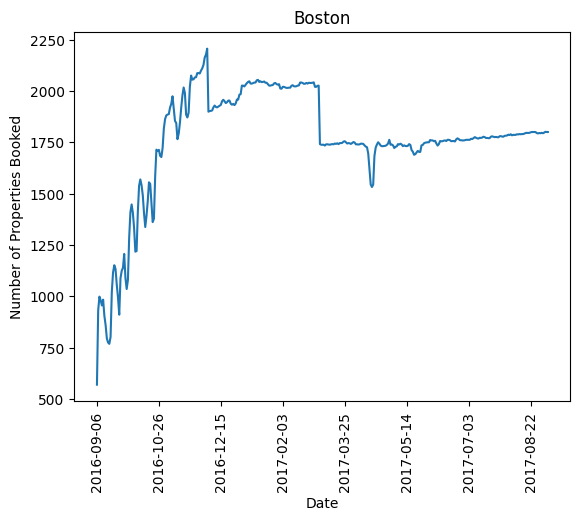

In [270]:
# plot the same graph as above with the Boston data.
popularity_by_date_boston = boston_calendar.groupby('date')['booked'].sum()
popularity_by_date_boston.plot(kind='line', rot=90);
plt.title('Boston')
plt.xlabel("Date")
plt.ylabel("Number of Properties Booked")
plt.show()

In [271]:
#we now take a look at the most popular and least popular dates.
display(popularity_by_date_seattle.sort_values(ascending=False).head(1))
display(popularity_by_date_seattle.sort_values(ascending=True).head(1))

date
2017-01-01    2922
Name: booked, dtype: int64

date
2016-01-04    1735
Name: booked, dtype: int64

In [272]:
#we can then compare the difference in mean prices across the dates.
seattle_max_book = seattle_calendar[seattle_calendar['date'] == '2017-01-01']
seattle_min_book = seattle_calendar[seattle_calendar['date'] == '2016-01-04']
display(seattle_calendar['price'].mean())
display(seattle_max_book['price'].mean())
display(seattle_min_book['price'].mean())

137.19222676140043

137.53664383561645

122.08587896253603

In [273]:
#apply the same calculation to Boston.
display(popularity_by_date_boston.sort_values(ascending=False).head(1))
display(popularity_by_date_boston.sort_values(ascending=True).head(1))

date
2016-12-04    2207
Name: booked, dtype: int64

date
2016-09-06    570
Name: booked, dtype: int64

In [274]:
boston_max_book = boston_calendar[boston_calendar['date'] == '2016-12-04']
boston_min_book = boston_calendar[boston_calendar['date'] == '2016-09-06']
display(boston_calendar['price'].mean())
display(boston_max_book['price'].mean())
display(boston_min_book['price'].mean())

192.45390955690283

179.81326669695594

239.71001757469244

By looking at the average 'price' value at the most popular and least popular date of booking, we can see if there's any shifting because of demand. Interestingly, it's cheaper to book Boston at the peak time relative to the yearly average. 

**Question 3 - Where can we get the best value for money?**

In order to calculate the value for money, it requires looking at more than just the cost. We also expect high quality, therefore for this section, we'll need to combine overall costs with some reviews.

In [275]:
# Three columns in the listings dataframe contribute to the overall costs - price, cleaning fee and deposit. 
# So we start wth converting all these required columns to numerical types using the previously defined 'price_col_to_numeric' function.
seattle_listings = price_col_to_numeric(seattle_listings, 'price')
seattle_listings = price_col_to_numeric(seattle_listings, 'cleaning_fee')
seattle_listings = price_col_to_numeric(seattle_listings, 'security_deposit')

In [276]:
#do the same with Bosoton.
boston_listings = price_col_to_numeric(boston_listings, 'price')
boston_listings = price_col_to_numeric(boston_listings, 'cleaning_fee')
boston_listings = price_col_to_numeric(boston_listings, 'security_deposit')

In [277]:
# To take into account the size of the letting, and the fact the sharing with other people 
# does reduce the per person price, we create a new column which accounts for this.
def price_per_person(df, new_col_name, col):
    """
    This function produces a new column which represents a value per person.
    ---
    input:
       df = dataframe
       new_col_name = name of the new column you want to create
       col = name of the column you want to work out the per person value of.
    output:
       df with a new per person column.
    """
    df[new_col_name] = df[col] / df["accommodates"]
    return df

In [278]:
#calculate the overall cost per person.
seattle_listings = price_per_person(seattle_listings, 'price_per_person', 'price')
seattle_listings = price_per_person(seattle_listings, 'cleaning_per_person', 'cleaning_fee')
seattle_listings = price_per_person(seattle_listings, 'security_per_person', 'security_deposit')
seattle_listings['cost_per_person'] = seattle_listings["price_per_person"] + seattle_listings['cleaning_per_person'] + seattle_listings['security_per_person']

In [279]:
#do the same with Bosoton.
boston_listings = price_per_person(boston_listings, 'price_per_person', 'price')
boston_listings = price_per_person(boston_listings, 'cleaning_per_person', 'cleaning_fee')
boston_listings = price_per_person(boston_listings, 'security_per_person', 'security_deposit')
boston_listings['cost_per_person'] = boston_listings["price_per_person"] + boston_listings['cleaning_per_person'] + boston_listings['security_per_person']

In [280]:
display(seattle_listings['cost_per_person'].mean())
display(boston_listings['cost_per_person'].mean())

146.8128295607145

183.63463421954802

Unsurprisingly, the cost per person is still cheaper in Seattle but it's good to check. We now need to take these costs and combine it with reviews to see where we can get goo budget options.

In [281]:
# We create a new column, which indicates that if a letting is below the mean price for that city and the review score is still high,
# we flag that as a good budget option and it gets given a value of 1. If this doesn't apply, it gets a value of 0.
def value_for_money_seattle(row):
    '''
    Creates a new column if a property is considered a good budget option.
    ---
    input:
       row = name of the new column you want to create.
    output:
       df with new column.
    '''
    if (row['cost_per_person'] <= 146.8128295607145) & (row['review_scores_rating'] >= 90):
       return 1
    else:
       return 0

In [282]:
#apply this new function to the dataframe and see how many budget options are classed as a good budget option.
seattle_listings['value_for_money'] = seattle_listings.apply(value_for_money_seattle, axis=1)
display((seattle_listings['value_for_money'].sum())/(seattle_listings.shape[0]/2) * 100)

40.963855421686745

In [283]:
def value_for_money_boston(row):
    '''
    Creates a new column if a property is considered a good budget option.
    ---
     input:
       row = name of the new column you want to create.
    output:
       df with new column.
    '''
    if (row['cost_per_person'] <= 198.53066925092787) & (row['review_scores_rating'] >= 90):
       return 1
    else:
       return 0

In [284]:
# do the same thing with the Boston data.
boston_listings['value_for_money'] = boston_listings.apply(value_for_money_boston, axis=1)
display((boston_listings['value_for_money'].sum())/(boston_listings.shape[0]/2) * 100)

27.726638772663875

You're more likely to get a good budget option in Seattle as a 41% of listings under the average cost per person value still have a review score of over 90, as oppose to only 24% in Boston. On top of a budget option, we also want to look at where provides the best value for money, even if we're spending a bit more. Therefore, by dividing the 'review_scores_rating' with the mean value of 'cost_per_person', this gives us a new metric which measure the 'Satisfaction per Dollar'.

In [285]:
def satisfaction(df):
    '''
    Creates a new column to see where the best value per pound is based on previous reviews.
    ---
    input:
       df = dataframe
    output:
       df with a new 'Satisfaction per Dollar' column.
    '''
    df['Satisfaction per Dollar'] = (df['review_scores_rating'] / df['cost_per_person'].mean())
    df['Satisfaction per Dollar'] = (df['Satisfaction per Dollar'] - df['Satisfaction per Dollar'].min()) / (df['Satisfaction per Dollar'].max() - df['Satisfaction per Dollar'].min())
    return df['Satisfaction per Dollar'].mean()

In [286]:
# apply this new function to both dataframes.
display(satisfaction(seattle_listings))
display(satisfaction(boston_listings))

0.931740775780511

0.8989583333333334

This metric could also be further sliced if we wanted to look at only budget options but on the whole, better value for money is found in Seattle.

**Question 4 - Is there any other information we could abstract from the written reviews?**

Lastly, we know that the best location is Seattle when it comes to value for money. However, we want to check what the reviewers actually say about their experiences.

In [287]:
# Firstly, we filter the reviews dataframe to only contain highly rated listings.
def unique_reviews(df_listings, df_reviews):
    """
    Filter the reviews dataframe based on the listings dataframe.
    ---
    input:
       df_listings = the listings dataframe.
       df_reviews - the reviews dataframe.
    output:
       df_reviews only containing the listings which has a rating of over 90.
    """
    df_listings_90 = df_listings[df_listings['review_scores_rating'] >= 90]
    df_listings_list = df_listings_90['id'].unique().tolist()
    df_reviews = df_reviews[df_reviews['listing_id'].isin(df_listings_list)]
    return df_reviews

In [288]:
# we look at the amount of listings which are rated above 90.
display(len(seattle_reviews['listing_id'].unique().tolist()))
seattle_reviews = unique_reviews(seattle_listings, seattle_reviews)
display(len(seattle_reviews['listing_id'].unique().tolist()))

3191

2745

In [289]:
# We now further filter this dataframe looking only for reviews which mention the word 'location'.
seattle_comments = seattle_reviews[seattle_reviews['comments'].str.contains('location', na=False)]
display((len(seattle_comments['listing_id'].unique().tolist()))/(len(seattle_reviews['listing_id'].unique().tolist())) * 100)

85.42805100182149

In [290]:
# do the same thing with the Boston data.
display(len(boston_reviews['listing_id'].unique().tolist()))
boston_reviews = unique_reviews(boston_listings, boston_reviews)
display(len(boston_reviews['listing_id'].unique().tolist()))

2829

2052

In [291]:
boston_comments = boston_reviews[boston_reviews['comments'].str.contains('location', na=False)]
display((len(boston_comments['listing_id'].unique().tolist()))/(len(boston_reviews_df['listing_id'].unique().tolist())) * 100)

80.11695906432749

Of the listings which recieve a review score of higher than 90 and filtering the comments for the key word 'location', this shows the listings where location plays a role in determining the high review score. Of course, those doesn't mean that the comment regarding 'location' has to be positive, however it is likely due to the score rating and this is beneficial when planning a trip. As we can see, the percentage of listings is higher for Seattle compared to Boston.

**Evaluate the results**

We can make four conclusions from this analysis;

- The overall mean price is cheaper in Seattle.
- It is better to visit Boston at its peak time, where a better deal is found in Seattle at the least busy period.
- The budget options are rated higher in Seattle as well as better value for money.
- Based on reviews, the locations of the listings in Seattle is ranked higher.